In [1]:
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv("data/churn_modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


It's good to see that there are no missing values and few categorical columns

In [3]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

As I see there are only 3 classes in the *Geography* and 2 classes in the *Gender*. I think it would be appropiate to drop the first categorical column *Surname*, since it's unecessary.

In [4]:
df.drop(['Surname','RowNumber','CustomerId'], axis=1, inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# EDA

In [5]:
df.describe().style.background_gradient()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.705500,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.455840,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.000000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.000000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


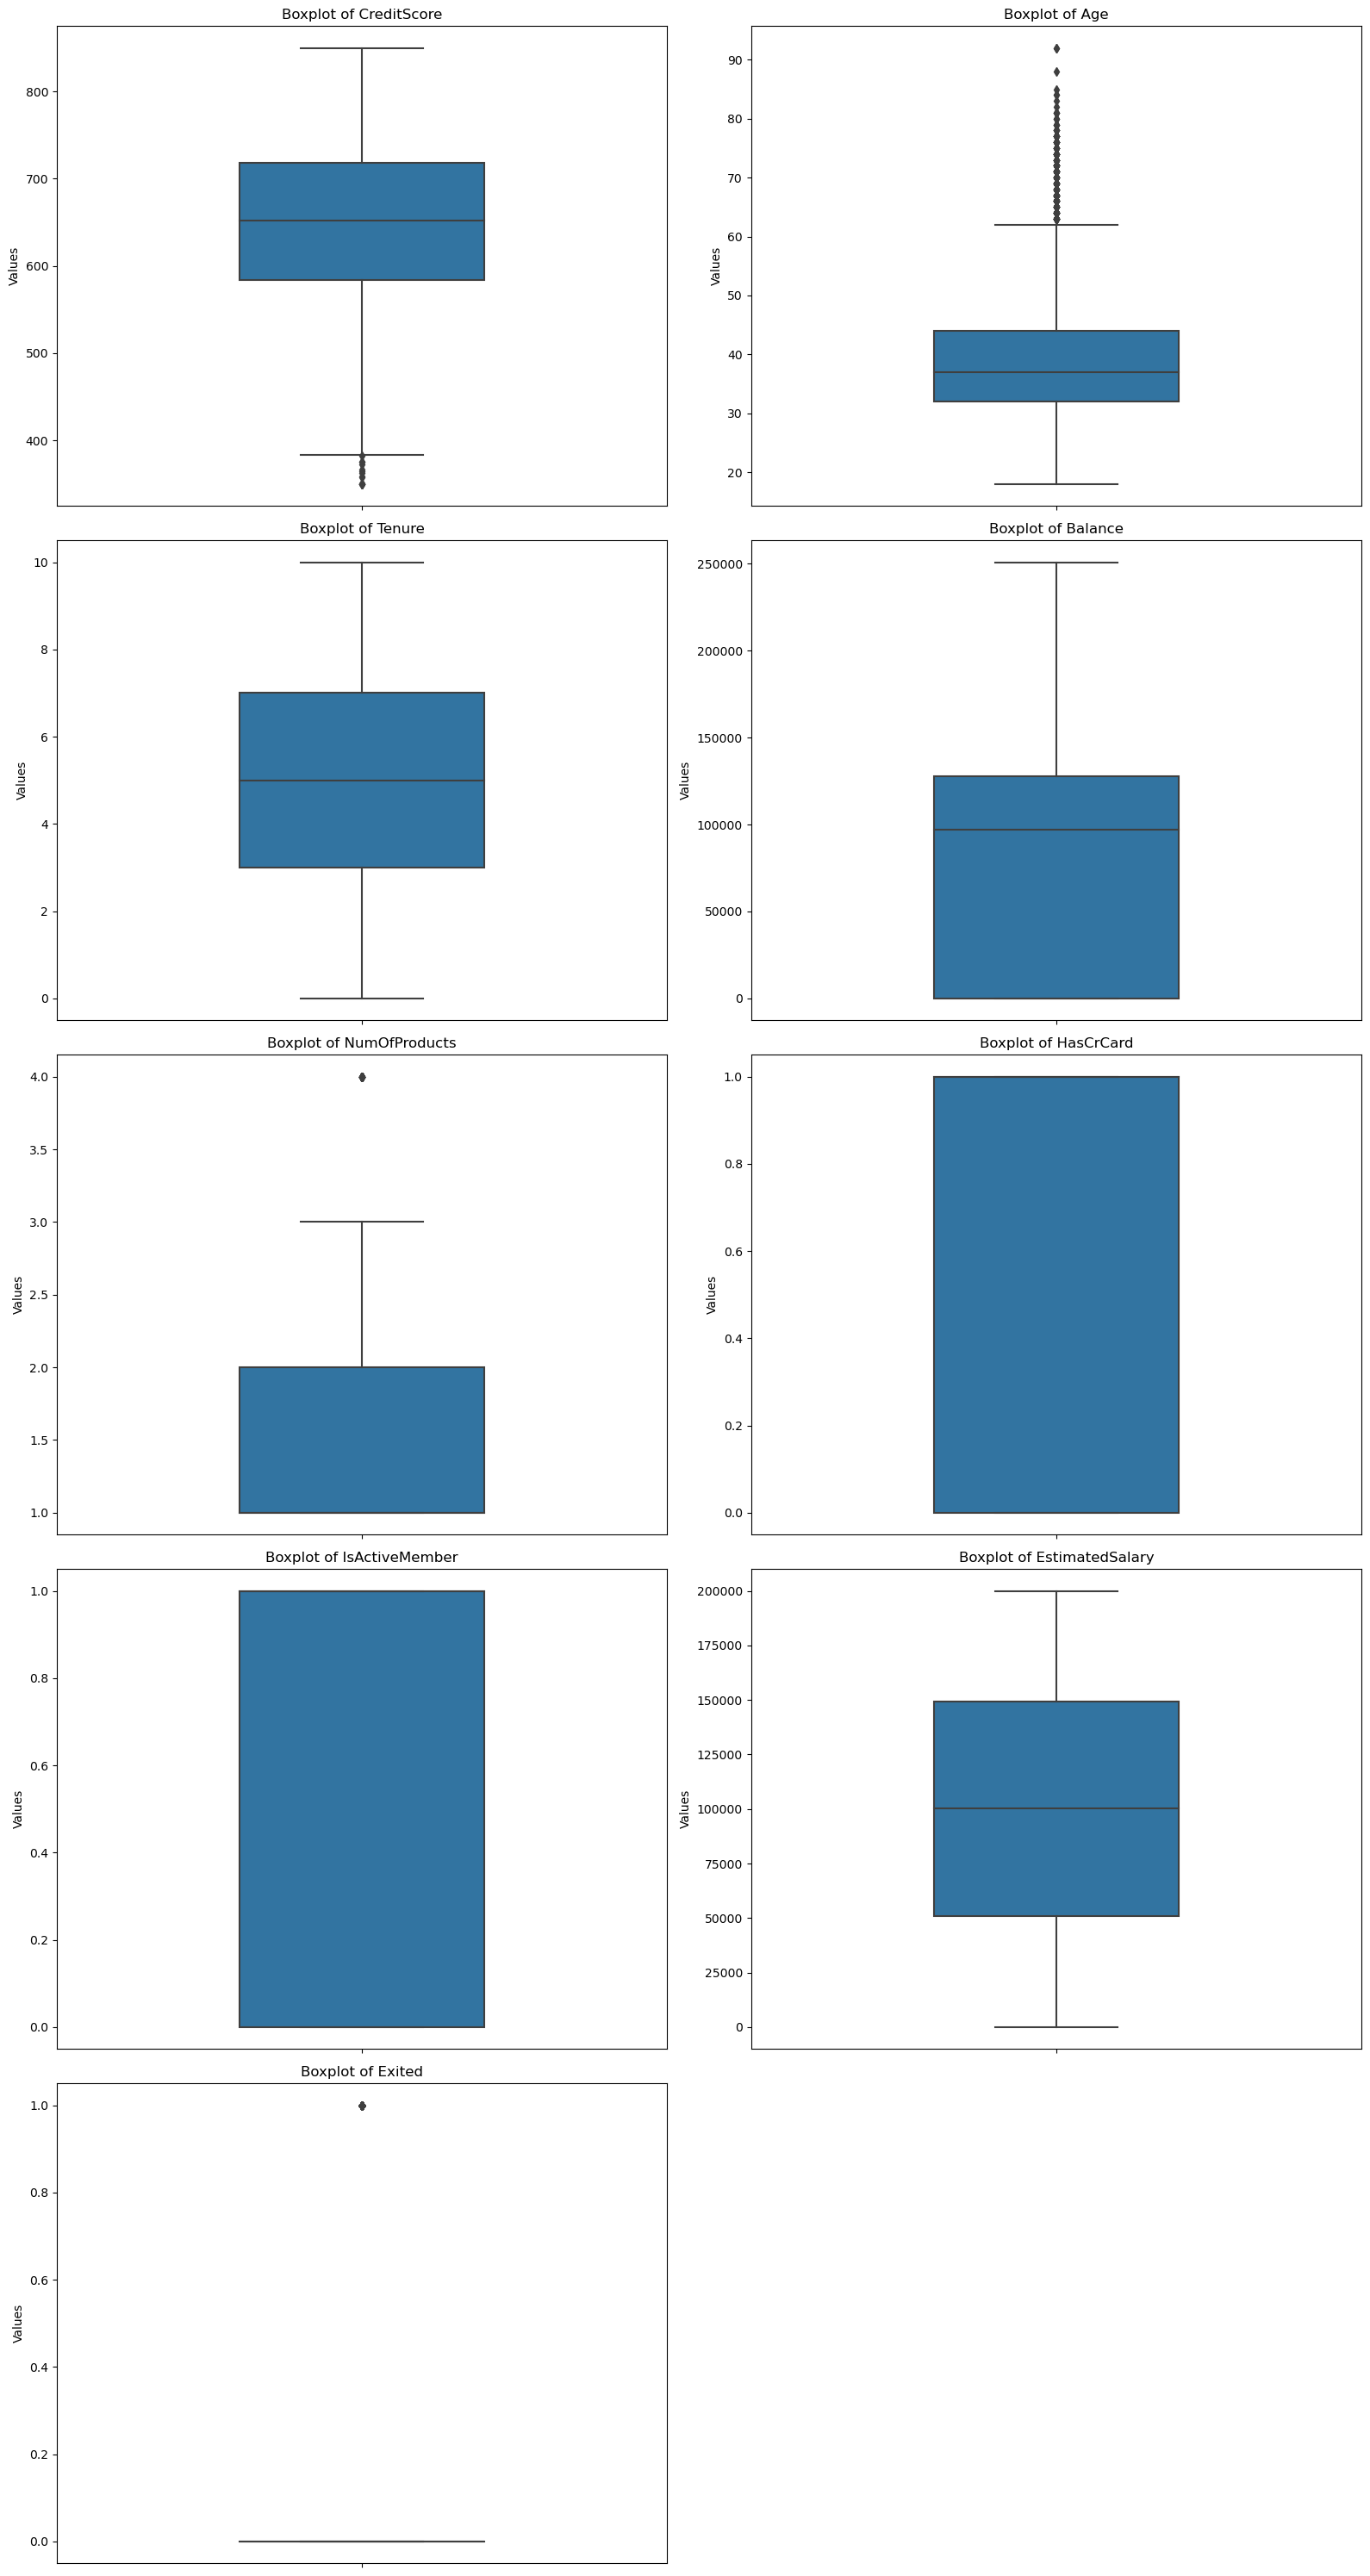

In [6]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

num_rows = math.ceil(len(numerical_columns) / 2)
fig, axs = plt.subplots(num_rows, 2, figsize=(16, 6*num_rows))

row = 0
for i, column in enumerate(numerical_columns):
    col = i % 2
    
    sns.boxplot(y=column, data=df, ax=axs[row, col], width=0.4)
    axs[row, col].set_title(f'Boxplot of {column}')
    axs[row, col].set_ylabel('Values')

    if (i + 1) % 2 == 0:
        row += 1

if len(numerical_columns) % 2 != 0:
    axs.flatten()[-1].axis('off')
plt.tight_layout()
plt.show()

The dataset is remarkably good, since outliers are present only *CreditScore* and *Age*.

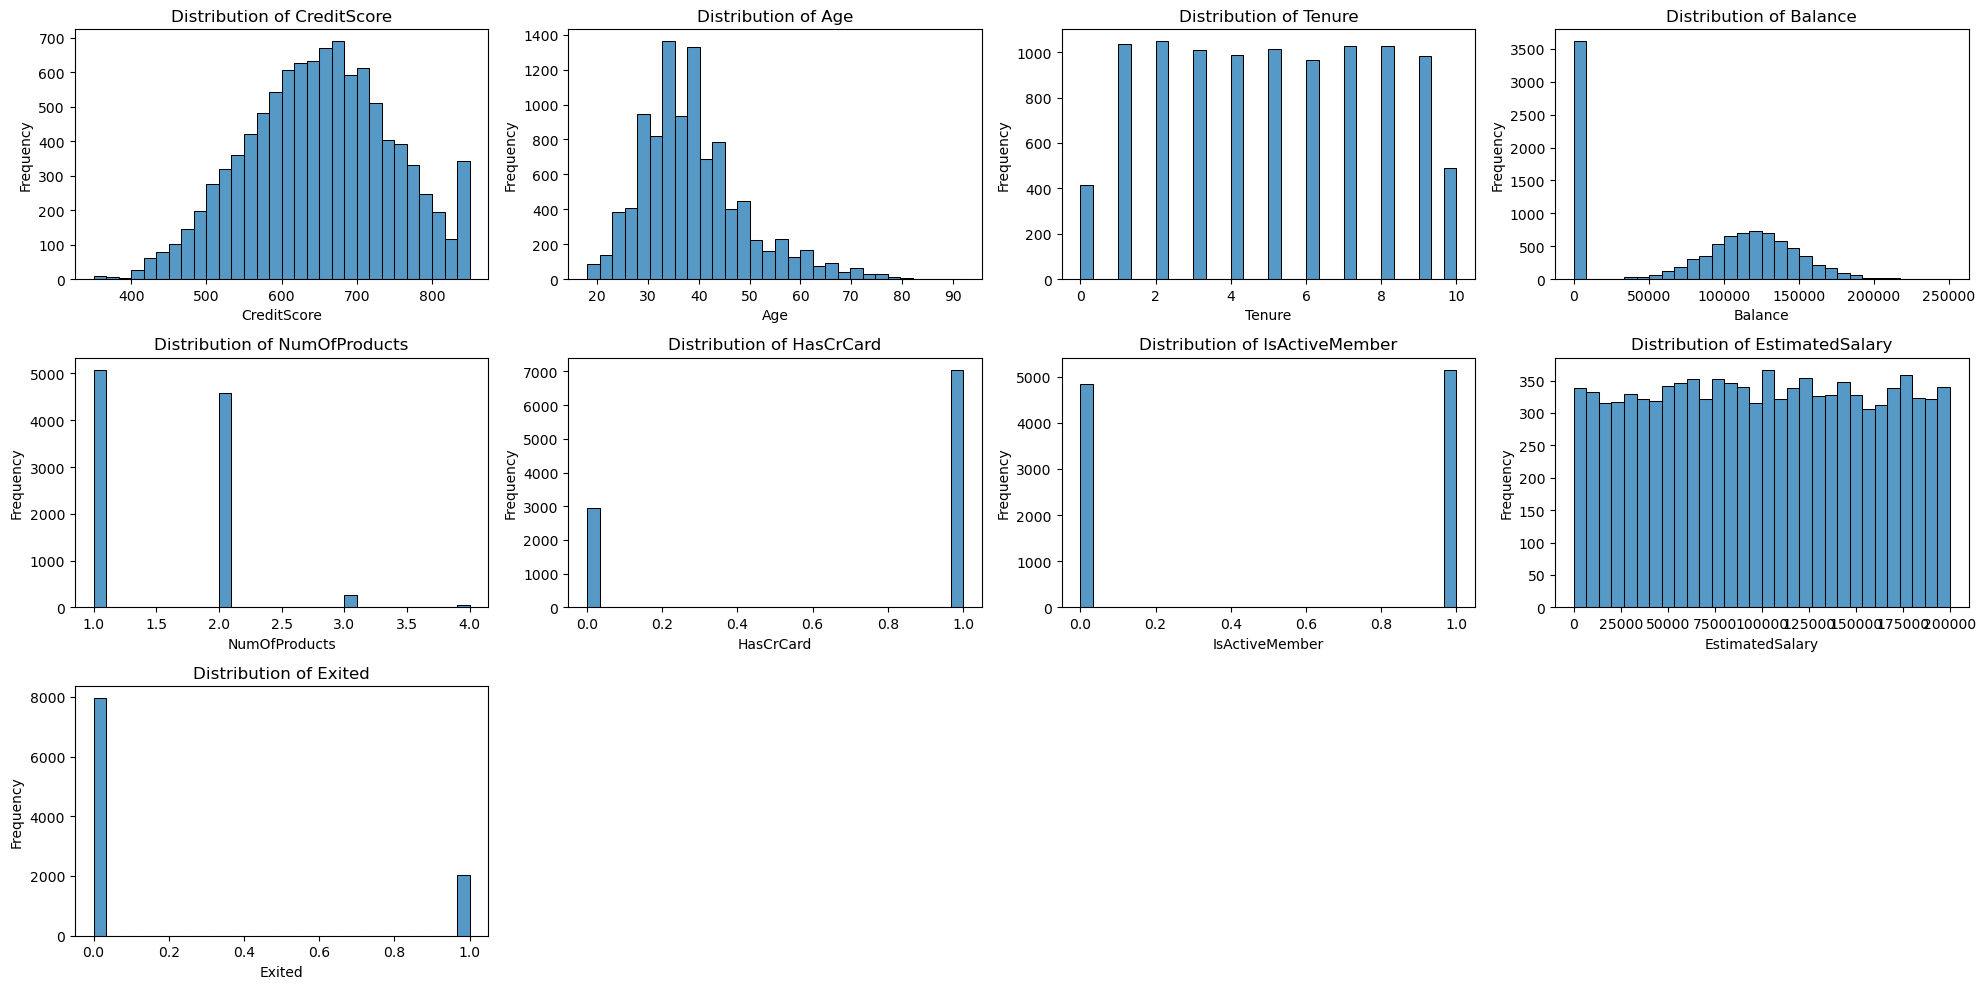

In [7]:
n_rows = 3
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))  


axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.histplot(df[col], bins=30, kde=False, ax=axes[i])  
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')


for i in range(len(numerical_columns), n_rows * n_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Almost all columns have a normal distribution except *Balance*.

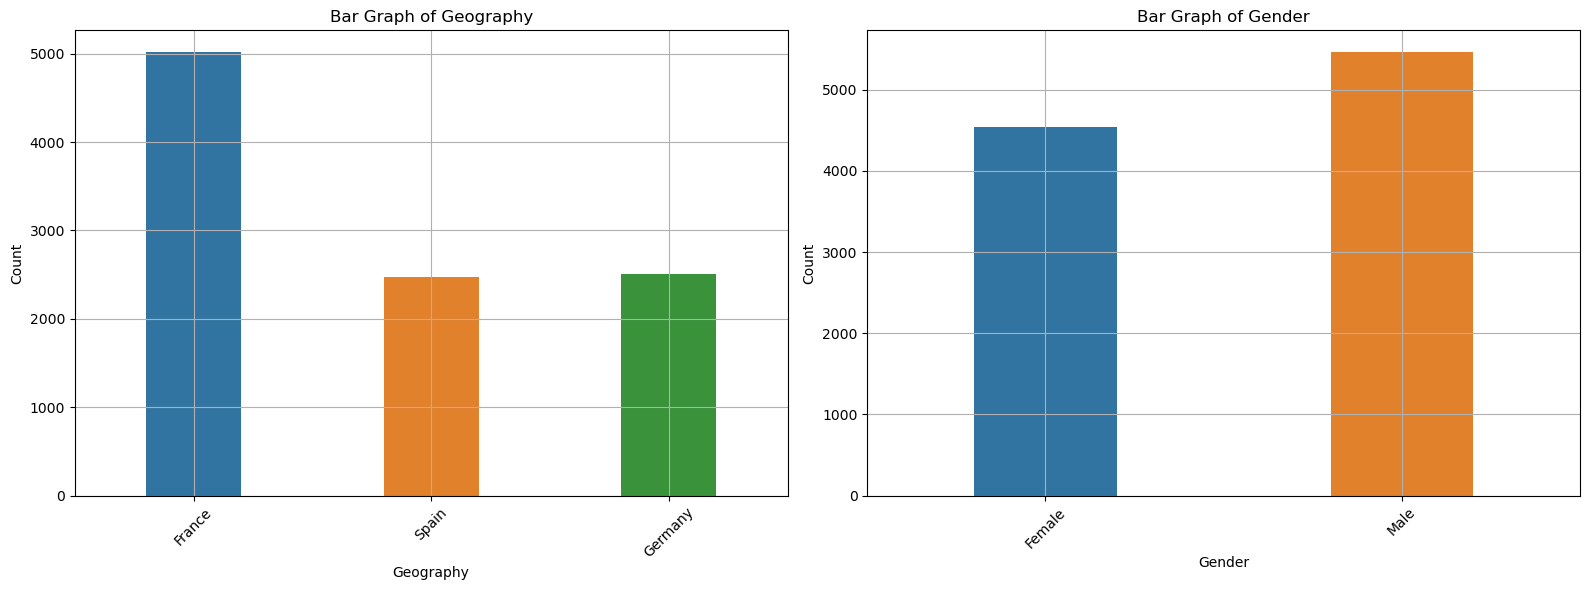

In [8]:
categorical_columns = df.select_dtypes(include=['object']).columns.to_list()
num_rows = math.ceil((len(categorical_columns)) / 2)
fig, axs = plt.subplots(num_rows, 2, figsize=(16, 6*num_rows)) if num_rows > 1 else plt.subplots(num_rows, 2, figsize=(16, 6*num_rows), squeeze=False)

row = 0
for i, column in enumerate(categorical_columns):
    col = i % 2
    sns.countplot(x=column, data=df, ax=axs[row, col], width=0.4)
    axs[row, col].set_title(f'Bar Graph of {column}')
    axs[row, col].set_xlabel(column)
    axs[row, col].set_ylabel('Count')
    axs[row, col].grid(True)
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=45)

    if (i + 1) % 2 == 0:
        row += 1

if len(categorical_columns) % 2 != 0:
    axs.flatten()[-1].axis('off')

plt.tight_layout()
plt.show()

**Observations:**
* Based on existing data, people around 30's are the most customers of the banks.
* A lot of customers are people with no money in their accounts.
* Mostly, people use only one product of the bank.
* The majority of the clients of the bank are from France.

## Data processing

In [9]:
from category_encoders import TargetEncoder
categorical_columns = df.select_dtypes(include=['object']).columns.to_list()

te = TargetEncoder(smoothing=1)

df_encoded = df.copy()
for col in categorical_columns:
    df_encoded[col] = te.fit_transform(df[col], df['Exited'])

df = df_encoded
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0.161548,0.250715,42,2,0.00,1,1,1,101348.88,1
1,608,0.166734,0.250715,41,1,83807.86,1,0,1,112542.58,0
2,502,0.161548,0.250715,42,8,159660.80,3,1,0,113931.57,1
3,699,0.161548,0.250715,39,1,0.00,2,0,0,93826.63,0
4,850,0.166734,0.250715,43,2,125510.82,1,1,1,79084.10,0


Using TargetEncoder for a small experiment.

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier

def mean_acc_model(X,y):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    y_pred = cross_val_predict(clf, X, y, cv=5)
    
    f1 = f1_score(y, y_pred, average='weighted')  
    print("F1 Score: %0.2f" % f1)
    conf_matrix = confusion_matrix(y, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    
X = df.drop('Exited', axis=1)  
y = df['Exited']
mean_acc_model(X,y)

F1 Score: 0.85
Confusion Matrix:
[[7670  293]
 [1077  960]]


In [11]:
from sklearn.covariance import EllipticEnvelope
iso_forest = EllipticEnvelope(random_state=42)

iso_forest.fit(df[['Age', 'CreditScore']])

outliers = iso_forest.predict(df[['Age', 'CreditScore']])

df_filtered = df[outliers != -1]

X = df_filtered.drop('Exited', axis=1)
y = df_filtered['Exited']

mean_acc_model(X, y)

F1 Score: 0.85
Confusion Matrix:
[[7099  240]
 [ 977  684]]


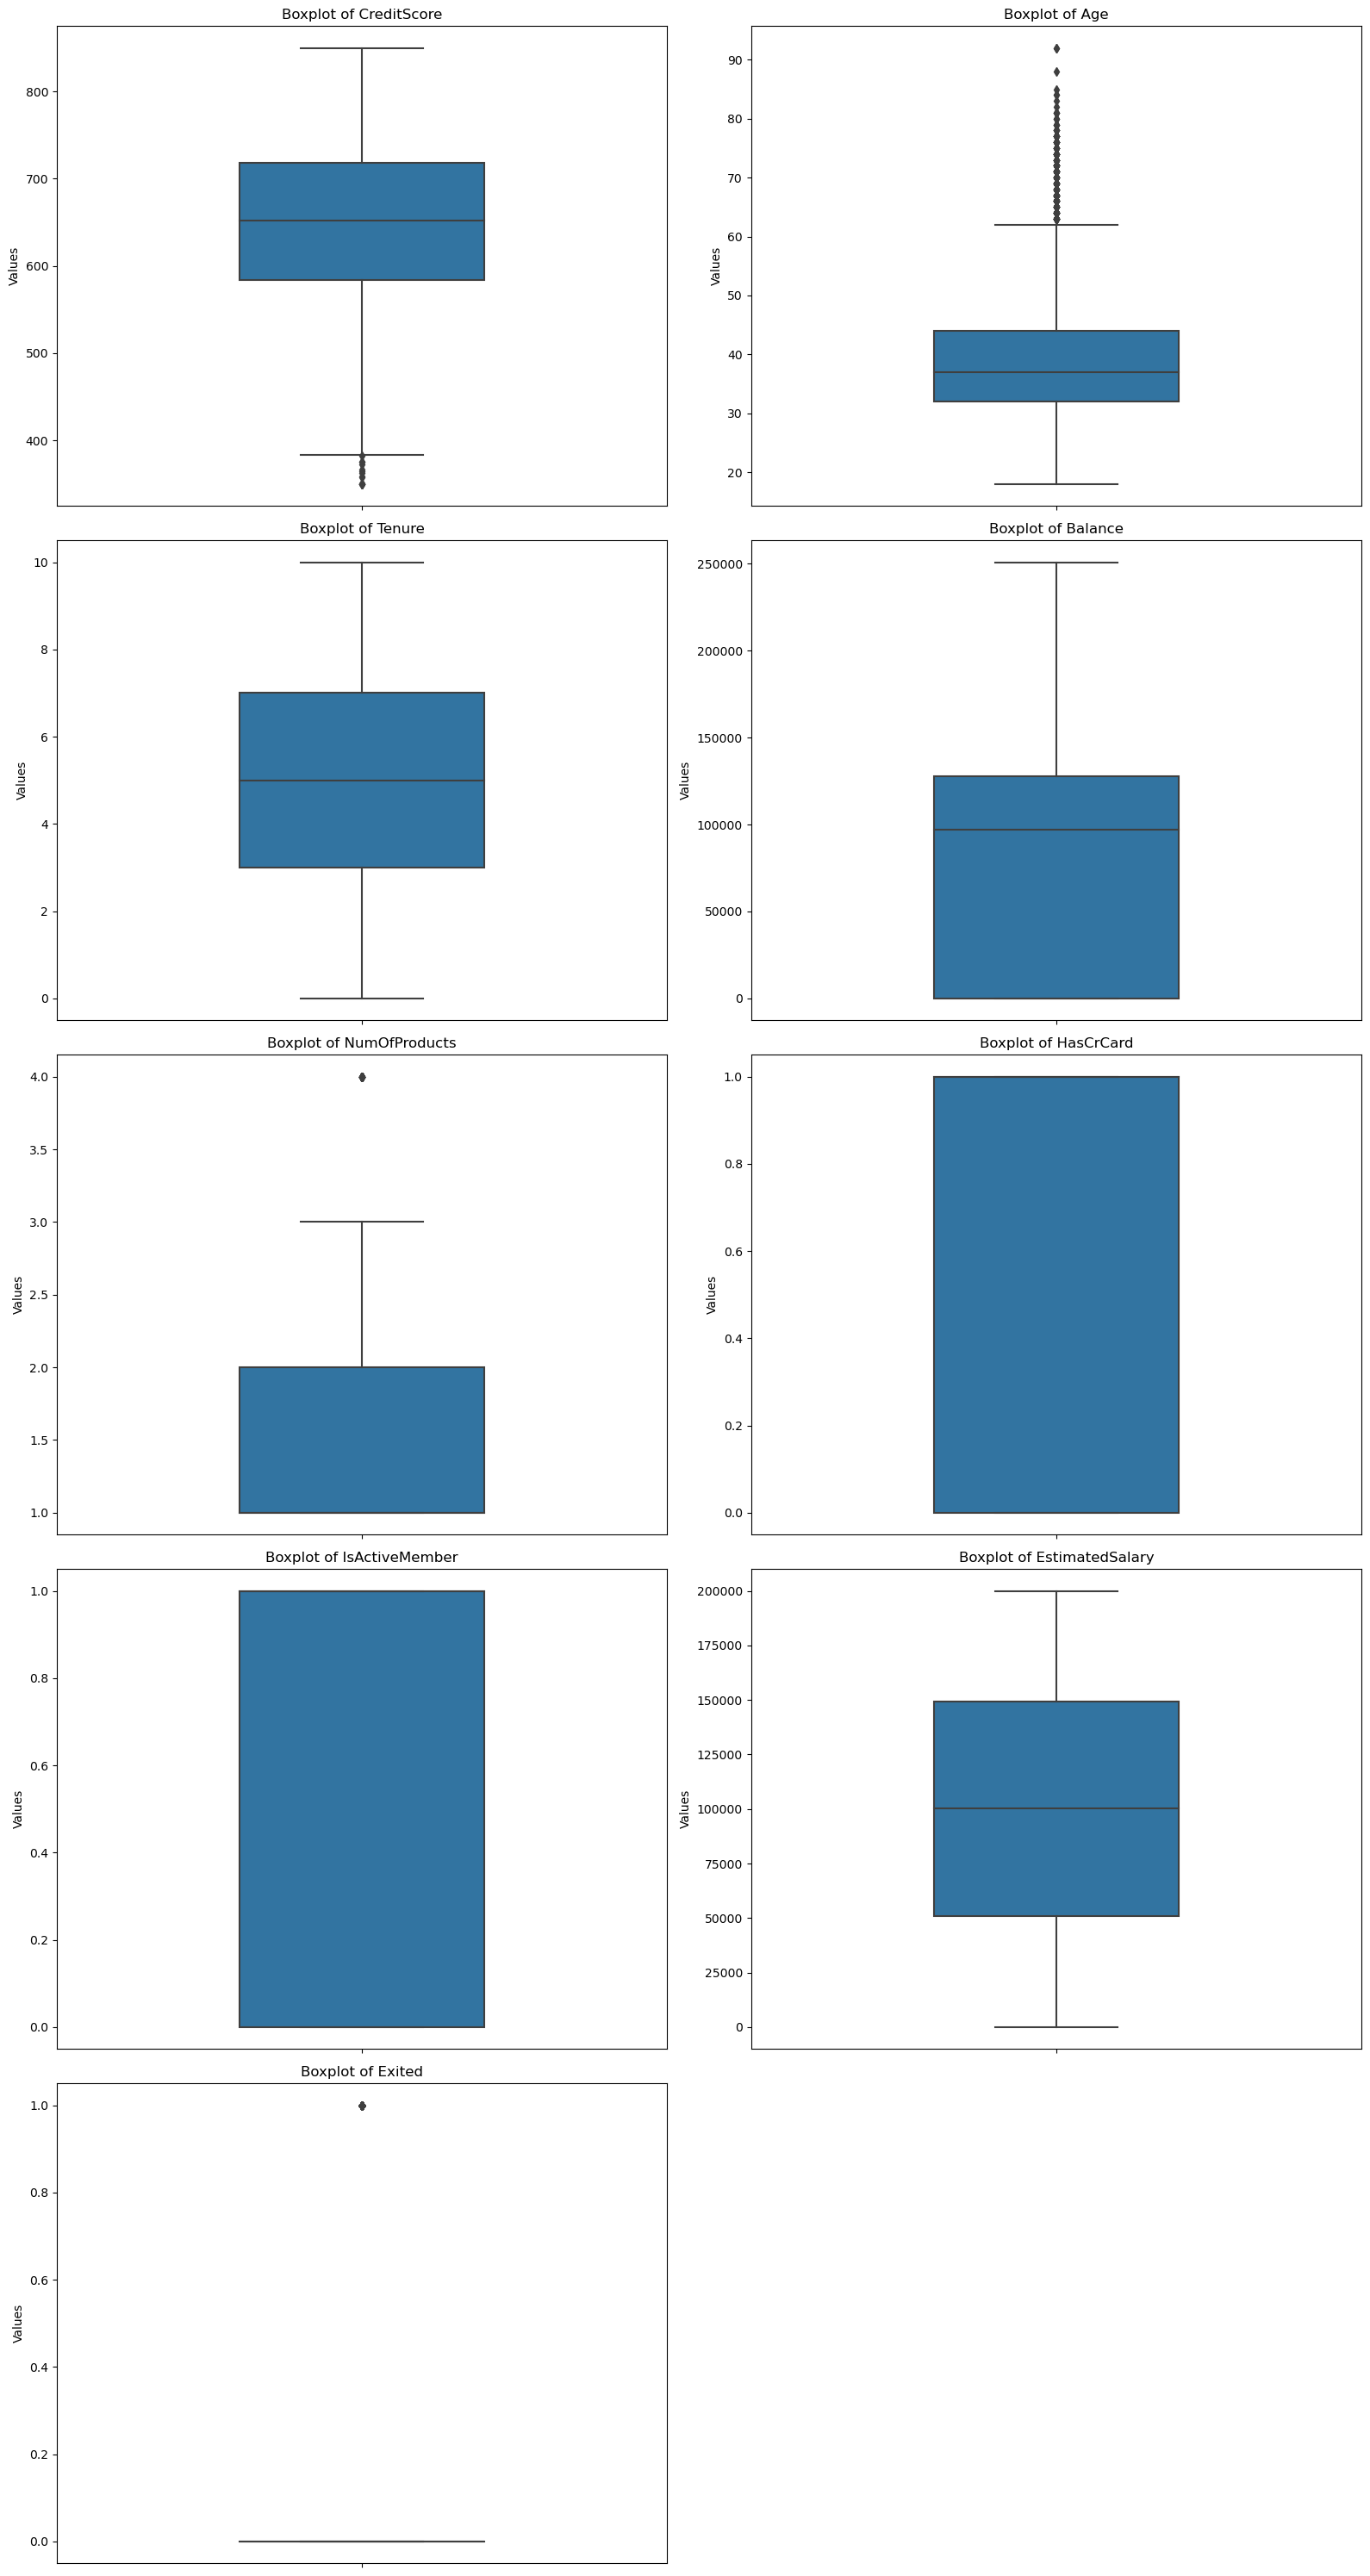

In [12]:
num_rows = math.ceil(len(numerical_columns) / 2)
fig, axs = plt.subplots(num_rows, 2, figsize=(16, 6*num_rows))

row = 0
for i, column in enumerate(numerical_columns):
    col = i % 2
    
    sns.boxplot(y=column, data=df, ax=axs[row, col], width=0.4)
    axs[row, col].set_title(f'Boxplot of {column}')
    axs[row, col].set_ylabel('Values')

    if (i + 1) % 2 == 0:
        row += 1

if len(numerical_columns) % 2 != 0:
    axs.flatten()[-1].axis('off')
plt.tight_layout()
plt.show()

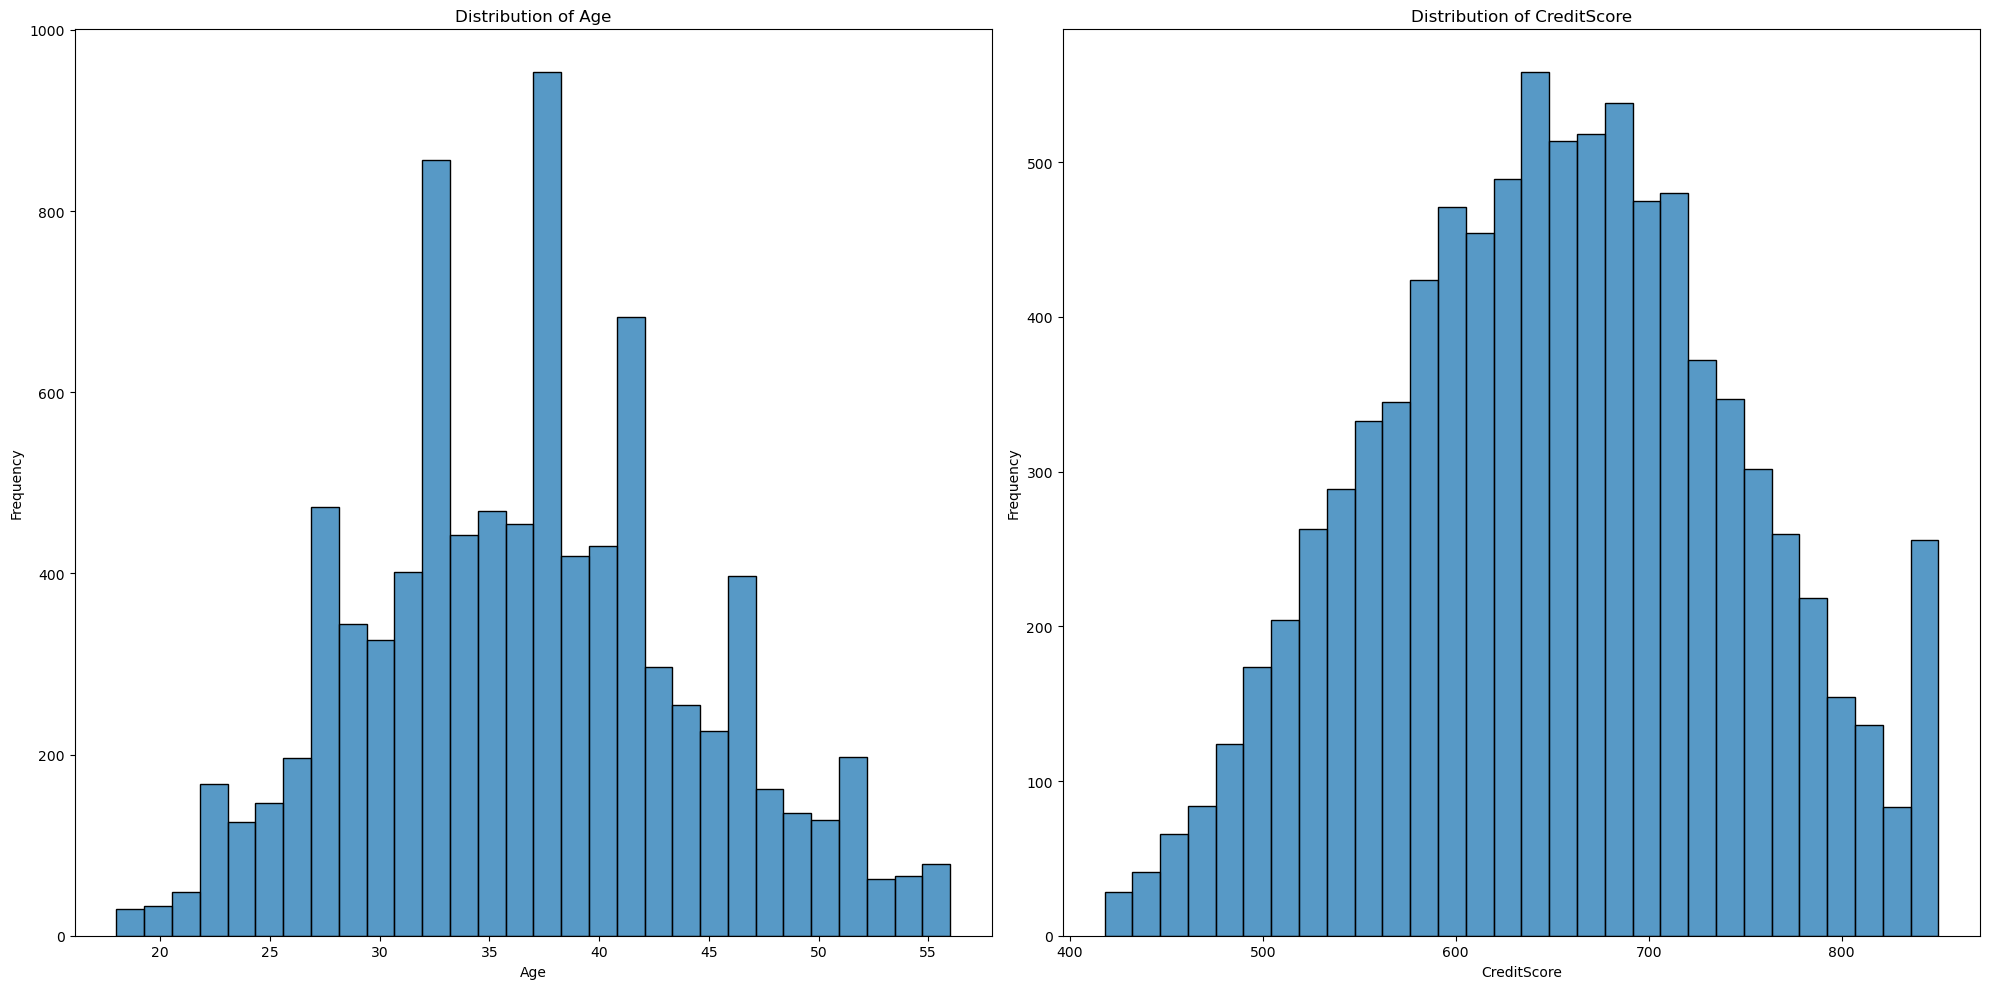

In [13]:
n_rows = 1
n_cols = 2
cols = ['Age', 'CreditScore']
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))  


axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(df_filtered[col], bins=30, kde=False, ax=axes[i])  
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')


for i in range(len(cols), n_rows * n_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In my opinion it is good to stay on removing outliers, because not only that it hasn't decreased the accuracy, but also normalized the *Age* column.

In [41]:
df = df_filtered
import pandas as pd
from imperio import BoxCoxTransformer
boxcox = BoxCoxTransformer()

normalized_df = boxcox.apply(df, target = 'Exited',columns=df.columns[df.columns != 'Exited'])
df = normalized_df

X = df.drop('Exited', axis=1)
y = df['Exited']

mean_acc_model(X, y)

F1 Score: 0.85
Confusion Matrix:
[[7095  244]
 [ 978  683]]


## Feature Selection

<Axes: >

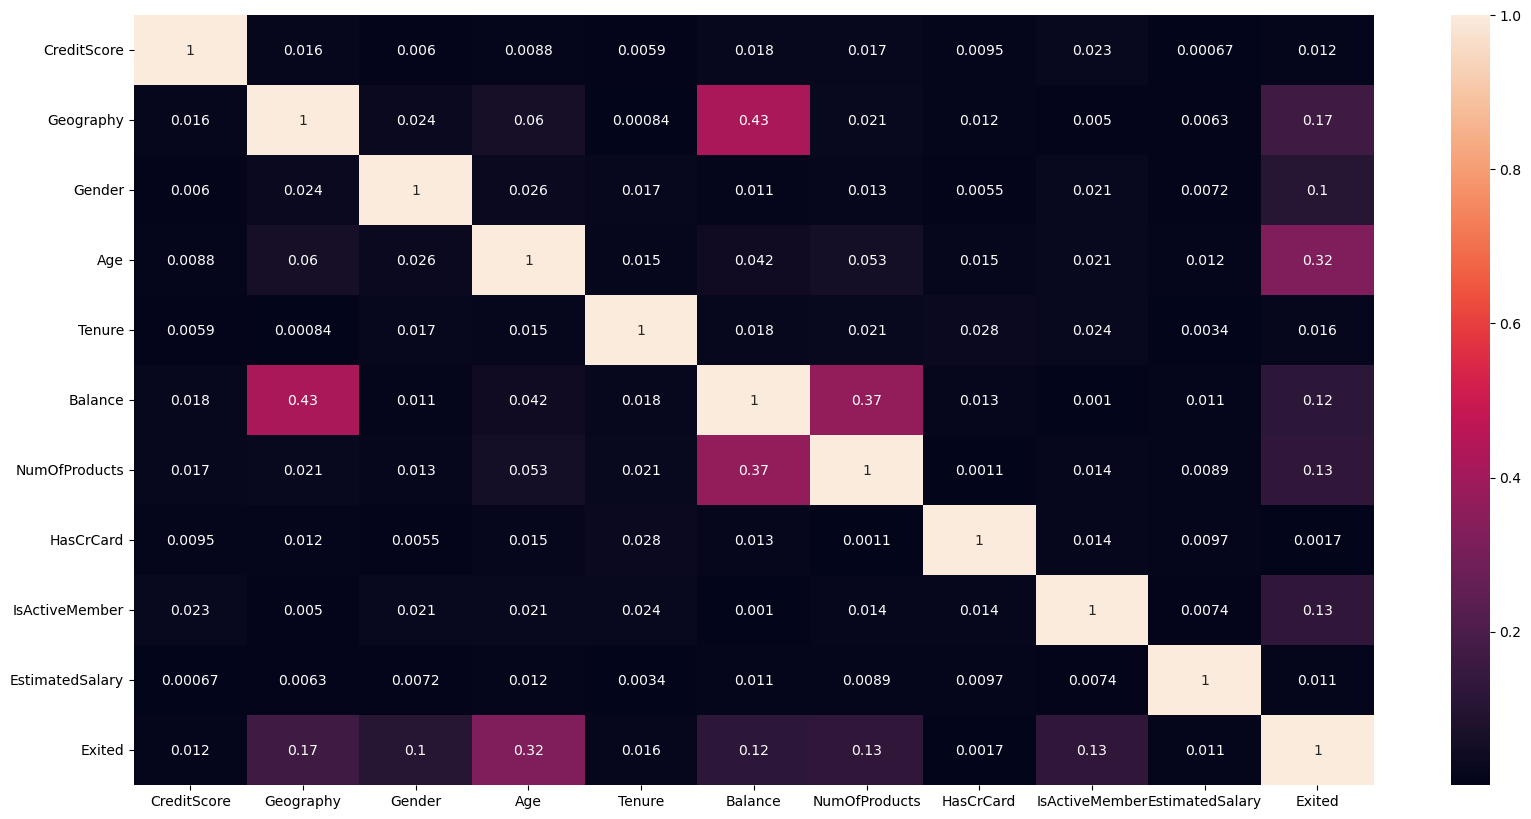

In [31]:
plt.figure(figsize=(20, 10))
correlation_matrix = df.corr().abs()
sns.heatmap(correlation_matrix, annot=True)

In [32]:
sorted_correlations = correlation_matrix['Exited'].sort_values(ascending=False)
sorted_correlations

Exited             1.000000
Age                0.323696
Geography          0.168256
NumOfProducts      0.127094
IsActiveMember     0.126171
Balance            0.118321
Gender             0.103069
Tenure             0.016151
CreditScore        0.011854
EstimatedSalary    0.011181
HasCrCard          0.001676
Name: Exited, dtype: float64

In [62]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
X = df.drop('Exited', axis=1)  
y = df['Exited']

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(df.drop('Exited', axis=1), df['Exited'], test_size=0.2, random_state=42)


def evaluate_accuracy(X_train, X_test, y_train, y_test, columns=None):
    if columns is not None:
        X_train = X_train[columns]
        X_test = X_test[columns]
    
   
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='weighted')  
    return f1

methods = ['No feature selection', 'PointBiserialCorrSelector', 'SelectKBest']
results = []

# No feature selection
accuracy_no_selection = evaluate_accuracy(X_train, X_test, y_train, y_test)
results.append(['No f. selection', 'N/A', accuracy_no_selection])

# PointBiserialCorrSelector
s_column_point_biserial = point_biserial.select(df, 'Exited')
accuracy_point_biserial = evaluate_accuracy(X_train, X_test, y_train, y_test, s_column_point_biserial)
results.append(['PointBiserialCorrSelector', len(s_column_point_biserial), accuracy_point_biserial])

# SelectKBest
selector = SelectKBest(chi2, k=5)
X_selected_kbest = selector.fit_transform(X_scaled, y)
selected_columns_kbest = X.columns[selector.get_support()]
accuracy_kbest = evaluate_accuracy(X_train, X_test, y_train, y_test, selected_columns_kbest)
results.append(['SelectKBest', len(selected_columns_kbest), accuracy_kbest])

columns = ['Method', 'Nr of Selected Columns', 'Accuracy']
df_results = pd.DataFrame(results, columns=columns)

df_results

,Method,Nr of Selected Columns,Accuracy
0,No f. selection,N/A,0.839593
1,PointBiserialCorrSelector,6,0.834024
2,SelectKBest,5,0.840493


I think its the safest to stay of the *SelectKBest* since it decreased the dimensionality and maintained the accuracy.

## Class Balancing

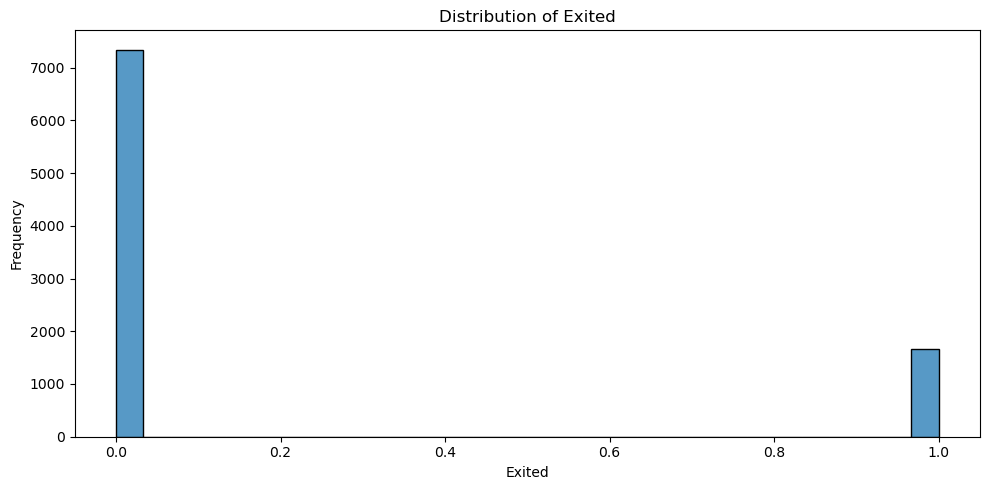

In [70]:
cols = ['Exited']

plt.figure(figsize=(10, 5))

sns.histplot(df[cols[0]], bins=30, kde=False)
plt.title(f'Distribution of {cols[0]}')
plt.xlabel(cols[0])
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

As seen, there are a lot of values for the *0* class and about 1/3 values for the *1* class.

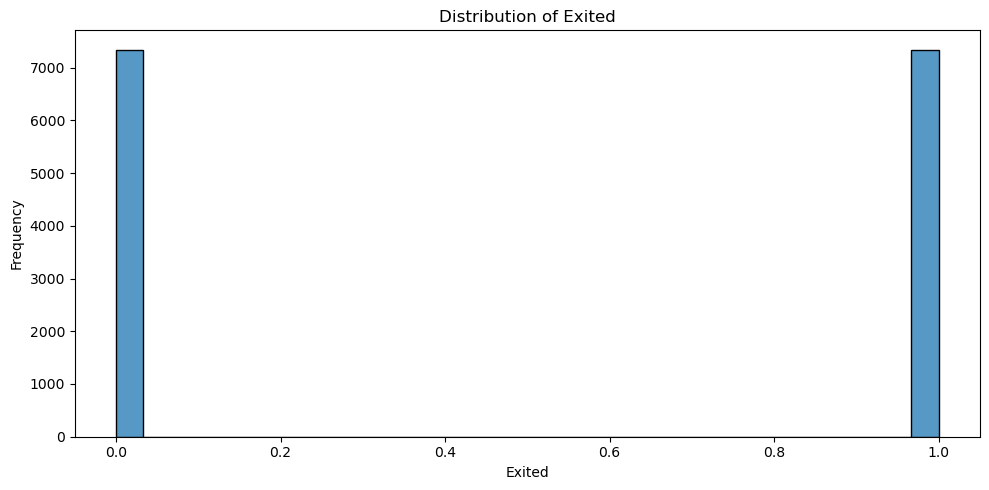

In [72]:
from crucio import SMOTE
smote = SMOTE()
balanced_df = smote.balance(df, 'Exited')

cols = ['Exited']

plt.figure(figsize=(10, 5))

sns.histplot(balanced_df[cols[0]], bins=30, kde=False)
plt.title(f'Distribution of {cols[0]}')
plt.xlabel(cols[0])
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [75]:
X = balanced_df.drop('Exited', axis=1)  
y = balanced_df['Exited']
mean_acc_model(X,y)

F1 Score: 0.90
Confusion Matrix:
[[6945  394]
 [1117 6222]]


Used SMOTE since is the most popular oversampling method. Haven't used SMOTEEN because I already filtered the data from the outliers.
As it can be seen, the accuracy has raised by 10% which is a pretty good result.

# Model Training

In [109]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
df = balanced_df
X = df[selected_columns_kbest]
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVC (Sigmoid)': SVC(kernel='sigmoid', degree=3, random_state=42),
    'XGBClassifier': XGBClassifier(random_state=42),
    'LGBMClassifier': LGBMClassifier(random_state=42)
}

model_f1_scores = pd.DataFrame(columns=['Model Name', 'F1 Score'])

for model_name, model in models.items():
   
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
  
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Model: {model_name}")
#     ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
#     plt.title(f"Confusion Matrix - {model_name}")
#     plt.show()
    print(classification_report(y_test, y_pred))
    model_f1_scores.loc[len(model_f1_scores)] = [model_name, f1]

model_f1_scores = model_f1_scores.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)
model_f1_scores

Model: Random Forest
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      2201
           1       0.95      0.83      0.89      2203

    accuracy                           0.89      4404
   macro avg       0.90      0.89      0.89      4404
weighted avg       0.90      0.89      0.89      4404

Model: SVC (Sigmoid)
              precision    recall  f1-score   support

           0       0.30      0.30      0.30      2201
           1       0.30      0.30      0.30      2203

    accuracy                           0.30      4404
   macro avg       0.30      0.30      0.30      4404
weighted avg       0.30      0.30      0.30      4404

Model: XGBClassifier
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      2201
           1       0.96      0.85      0.90      2203

    accuracy                           0.91      4404
   macro avg       0.91      0.91      0.91      4404
weighted av

,Model Name,F1 Score
0,LGBMClassifier,0.908417
1,XGBClassifier,0.906339
2,Random Forest,0.893116
3,SVC (Sigmoid),0.298811


Now let's choose RandomForest for the further hyperparameter tunning and testing.

# Hyperparameter Tunning

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
}

rf_model = RandomForestClassifier()
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score", f1)

Best Hyperparameters: {'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'n_estimators': 150}
F1 Score 0.8687464190018686


Hyperparameter Tuning wasn't so successful, so we will consider the default parameters - the best.

# Using PCA

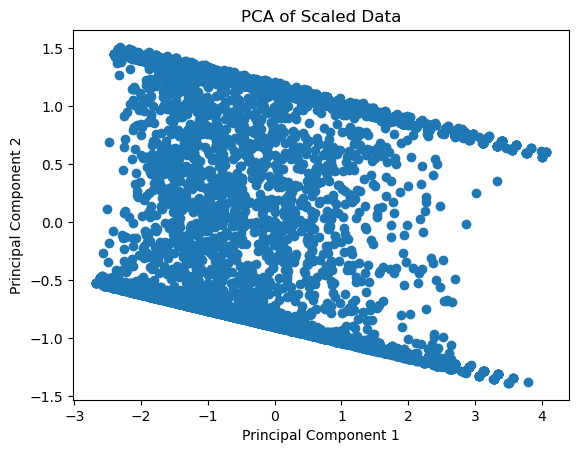

In [110]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

component_names = [f'Principal Component {i+1}' for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(data=X_pca, columns=component_names)

if X_pca.shape[1] >= 2:
    plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1])
    plt.title('PCA of Scaled Data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()
else:
    print("PCA did not reduce data to two components.")
    
X_pca.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Final Results and Conclusions

F1 Score: 0.88


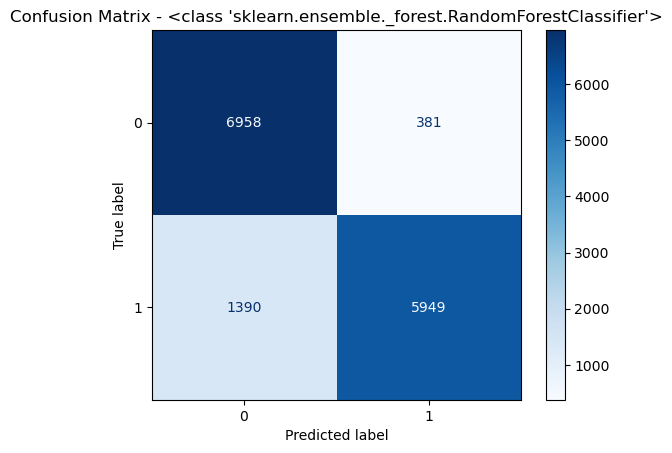

In [111]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_pred = cross_val_predict(clf, X_pca, y, cv=5)
f1 = f1_score(y, y_pred, average='weighted')  
print("F1 Score: %0.2f" % f1)
ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues')
plt.title(f"Confusion Matrix - {RandomForestClassifier}")
plt.show()

F1 Score: 0.88


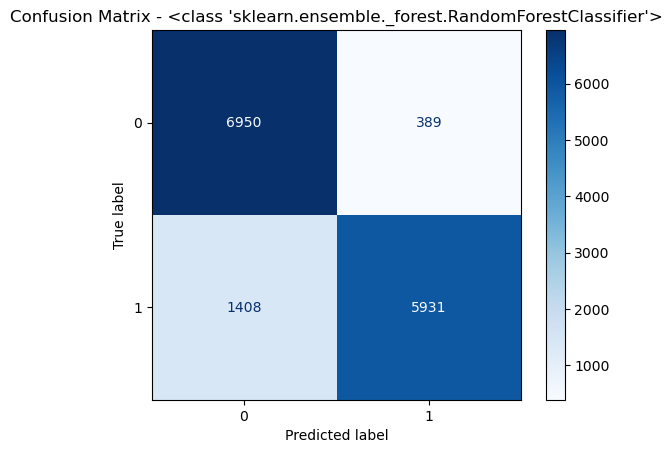

In [112]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_pred = cross_val_predict(clf, X, y, cv=5)
f1 = f1_score(y, y_pred, average='weighted')  
print("F1 Score: %0.2f" % f1)
ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues')
plt.title(f"Confusion Matrix - {RandomForestClassifier}")
plt.show()

**Conclusions:**
* Class Balancing and thus oversampling can boost the accuracy of the model.
* Hyperparameter Tunning is not always efficient. Sometimes the best hyperparamters are the default ones.
* In this case, after PCA accuracy results of the model were the same as before PCA, so we may conclude that PCA was neutral to the dataset.
* Feature Selection can be helpful, but not always efficient.